## Decision Tree

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import random
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

### Class Distribution

-----------------------------------
   health_index  count  proportion
0             1    974    0.381363
1             2    903    0.353563
2             0    677    0.265074
-----------------------------------


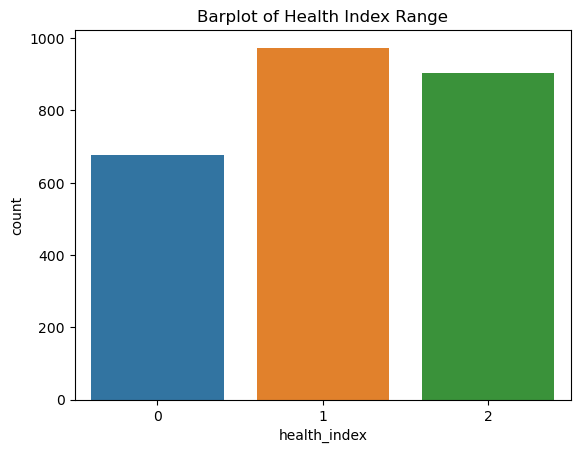

In [44]:
df = pd.read_csv('/Users/liumingqian/anly-501-project-liumingqian0511/data/01-modified-data/rand.csv')
conditions = [
    (df['ghindxx'] < 60),
    (df['ghindxx'] >= 60) & (df['ghindxx']<75),
    (df['ghindxx'] >= 75),
    ]

values = [0,1,2]
df['health_index'] = np.select(conditions, values)
distribution = df['health_index'].value_counts().reset_index().rename(columns={'index': 'health_index','health_index':'count'})
distribution['proportion'] = distribution['count']/len(df)
print('-----------------------------------')
print(distribution)
print('-----------------------------------')
ax = sns.barplot(x = 'health_index', y = 'count', data = distribution)
ax.set_title('Barplot of Health Index Range')

plt.show()

### Baseline Model

In [45]:
def random_classifier(y_data):
    random.seed(909391)
    ypred=[]
    max_label=np.max(y_data)
    for i in range(0,len(y_data)):
        ypred.append(np.random.choice(np.arange(max_label+1), p = distribution['proportion']))
    return ypred

In [46]:
def confusion_plot(y_data,y_pred):
    print('----------------------Classification Report---------------------------')
    print('ACCURACY:', accuracy_score(y_data, y_pred))
    print('RECALL (Y = Free):', recall_score(y_data, y_pred,labels=[0], average='weighted'))
    print('RECALL (Y = Coinsurance):', recall_score(y_data, y_pred,labels=[1], average='weighted'))
    print('RECALL (Y = Deductible):', recall_score(y_data, y_pred,labels=[2], average='weighted'))
    print('PRECISION (Y = Free):', precision_score(y_data,y_pred,labels=[0],average='weighted'))
    print('PRECISION (Y = Coinsurance):', precision_score(y_data,y_pred,labels=[1], average='weighted'))
    print('PRECISION (Y = Deductible):', precision_score(y_data,y_pred,labels=[2], average='weighted'))
    print('--------------------------Confusion Matrix-----------------------------')
    print(confusion_matrix(y_data,y_pred))
    ConfusionMatrixDisplay.from_predictions(y_data, y_pred)
    plt.show()

----------------------Classification Report---------------------------
ACCURACY: 0.3433829287392326
RECALL (Y = Free): 0.36336779911373707
RECALL (Y = Coinsurance): 0.3665297741273101
RECALL (Y = Deductible): 0.3034330011074197
PRECISION (Y = Free): 0.2567849686847599
PRECISION (Y = Coinsurance): 0.3979933110367893
PRECISION (Y = Deductible): 0.39198855507868385
--------------------------Confusion Matrix-----------------------------
[[246 256 175]
 [367 357 250]
 [345 284 274]]


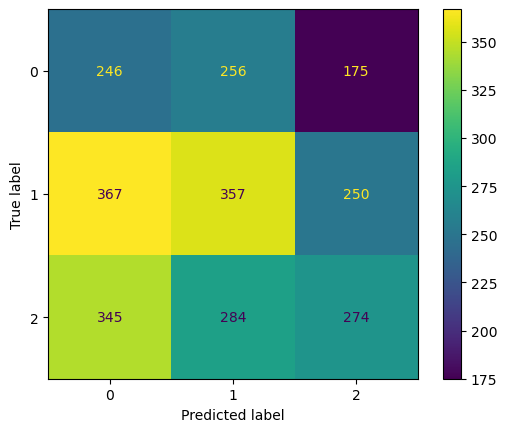

In [47]:
true_label = df['health_index']
predicted_label = random_classifier(true_label)
confusion_plot(true_label,predicted_label)

### Feature Selection

In [48]:
conditions = [
    (df['plan_type'] == 'Free'),
    (df['plan_type'] == 'Coinsurance'),
    (df['plan_type'] == 'Deductible'),
    (df['plan_type'] == 'Catastrophic')
    ]

values = [0,1,2,3]
df['plan'] = np.select(conditions, values)

In [49]:
Y = df['health_index']
X = df.drop(columns=['person','plan_type','catastrophic','free','health_index','ghindxx','face_to_face_visit','outpatient_expenses','totadm','total_expenses','inpdol_inf'])
ux = np.mean(X,axis = 0) # NORMALIZE X
sx = np.std(X,axis = 0)
for i in range(10):
    X.iloc[:,i] = (X.iloc[:,i] - ux[i])/sx[i]

#X['plan'] = df['plan']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

print("TRAINING SHAPES:",x_train.shape,y_train.shape)
print("TEST SHAPES:",x_test.shape,y_test.shape)

TRAINING SHAPES: (1787, 11) (1787,)
TEST SHAPES: (767, 11) (767,)


### Hyperparameter Tuning

In [50]:
def tunningResult(y_train, y_test, yp_train, yp_test,test_result, train_result):
    accuracy_train = accuracy_score(y_train, yp_train)
    recall_0_train = recall_score(y_train, yp_train,labels=[0], average='weighted')
    recall_1_train = recall_score(y_train, yp_train,labels=[1], average='weighted')
    recall_2_train = recall_score(y_train, yp_train,labels=[2], average='weighted')
    #recall_3_train = recall_score(y_train, yp_train,labels=[3], average='weighted')
    accuracy_test = accuracy_score(y_test, yp_test)
    recall_0_test = recall_score(y_test, yp_test,labels=[0], average='weighted')
    recall_1_test = recall_score(y_test, yp_test,labels=[1], average='weighted')
    recall_2_test = recall_score(y_test, yp_test,labels=[2], average='weighted')
    #recall_3_test = recall_score(y_test, yp_test,labels=[3], average='weighted')
    return [accuracy_train, recall_0_train,recall_1_train,recall_2_train],[accuracy_test,recall_0_test,recall_1_test,recall_2_test]

In [51]:
test_results=[]
train_results=[]

for depth in range(1,16):
    model = tree.DecisionTreeClassifier(max_depth=depth)
    model = model.fit(x_train,y_train)

    yp_train=model.predict(x_train)
    yp_test=model.predict(x_test)

    a,b = tunningResult(y_train, y_test, yp_train, yp_test,test_results, train_results)
    # print(y_pred.shape)
    test_results.append([depth]+b)
    train_results.append([depth]+a)

test_results = pd.DataFrame(test_results)
train_results = pd.DataFrame(train_results)

In [52]:
def resultPlot(train_results,test_results,param):
    fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2)
    fig.set_size_inches(20,10)
    ax1.plot(train_results[0],train_results[1],'-o')
    ax1.plot(test_results[0],test_results[1],'-o',color = 'darkred')
    ax1.set_xlabel("Number of layers in decision tree" + param)
    ax1.set_ylabel("ACCURACY: Training and Test")

    ax2.plot(train_results[0],train_results[2],'-o')
    ax2.plot(test_results[0],test_results[2],'-o',color = 'darkred')
    ax2.set_xlabel("Number of layers in decision tree" + param)
    ax2.set_ylabel("RECALL(Y=Free): Training and Test")

    ax3.plot(train_results[0],train_results[3],'-o')
    ax3.plot(test_results[0],test_results[3],'-o',color = 'darkred')
    ax3.set_xlabel("Number of layers in decision tree" + param)
    ax3.set_ylabel("RECALL(Y=Coinsurance): Training and Test")

    ax4.plot(train_results[0],train_results[4],'-o')
    ax4.plot(test_results[0],test_results[4],'-o',color = 'darkred')
    ax4.set_xlabel("Number of layers in decision tree" + param)
    ax4.set_ylabel("RECALL(Y=Deductible): Training and Test")

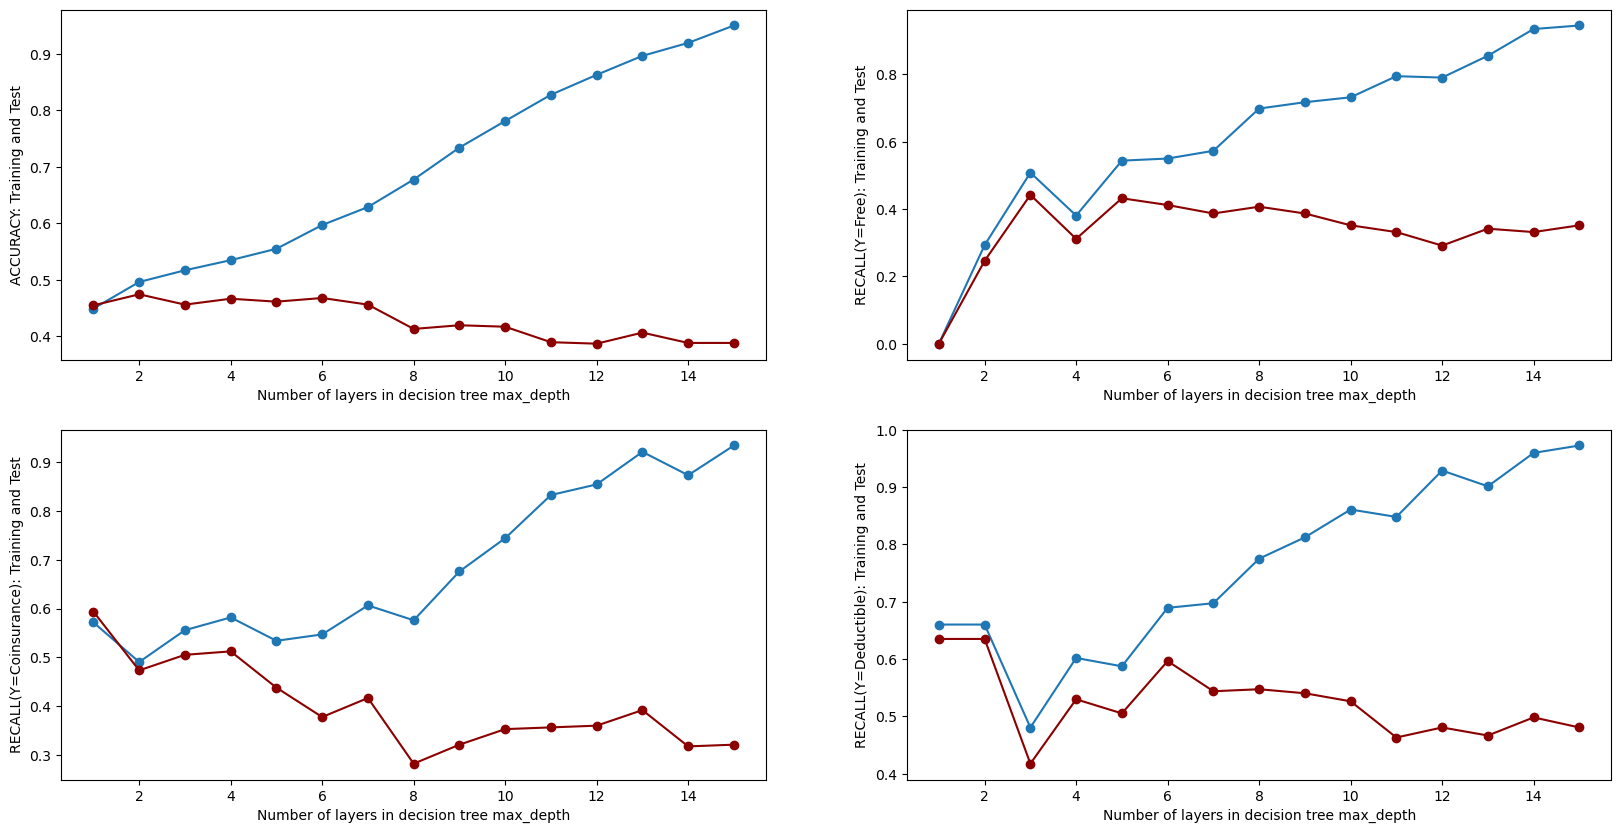

In [53]:
resultPlot(train_results,test_results, ' max_depth')

In [54]:
test_results=[]
train_results=[]

for num_sample in range(2,100):
    model = tree.DecisionTreeClassifier(min_samples_split=num_sample )
    model = model.fit(x_train,y_train)

    yp_train=model.predict(x_train)
    yp_test=model.predict(x_test)

    a,b = tunningResult(y_train, y_test, yp_train, yp_test,test_results, train_results)
    # print(y_pred.shape)
    test_results.append([num_sample]+b)
    train_results.append([num_sample]+a)

test_results = pd.DataFrame(test_results)
train_results = pd.DataFrame(train_results)

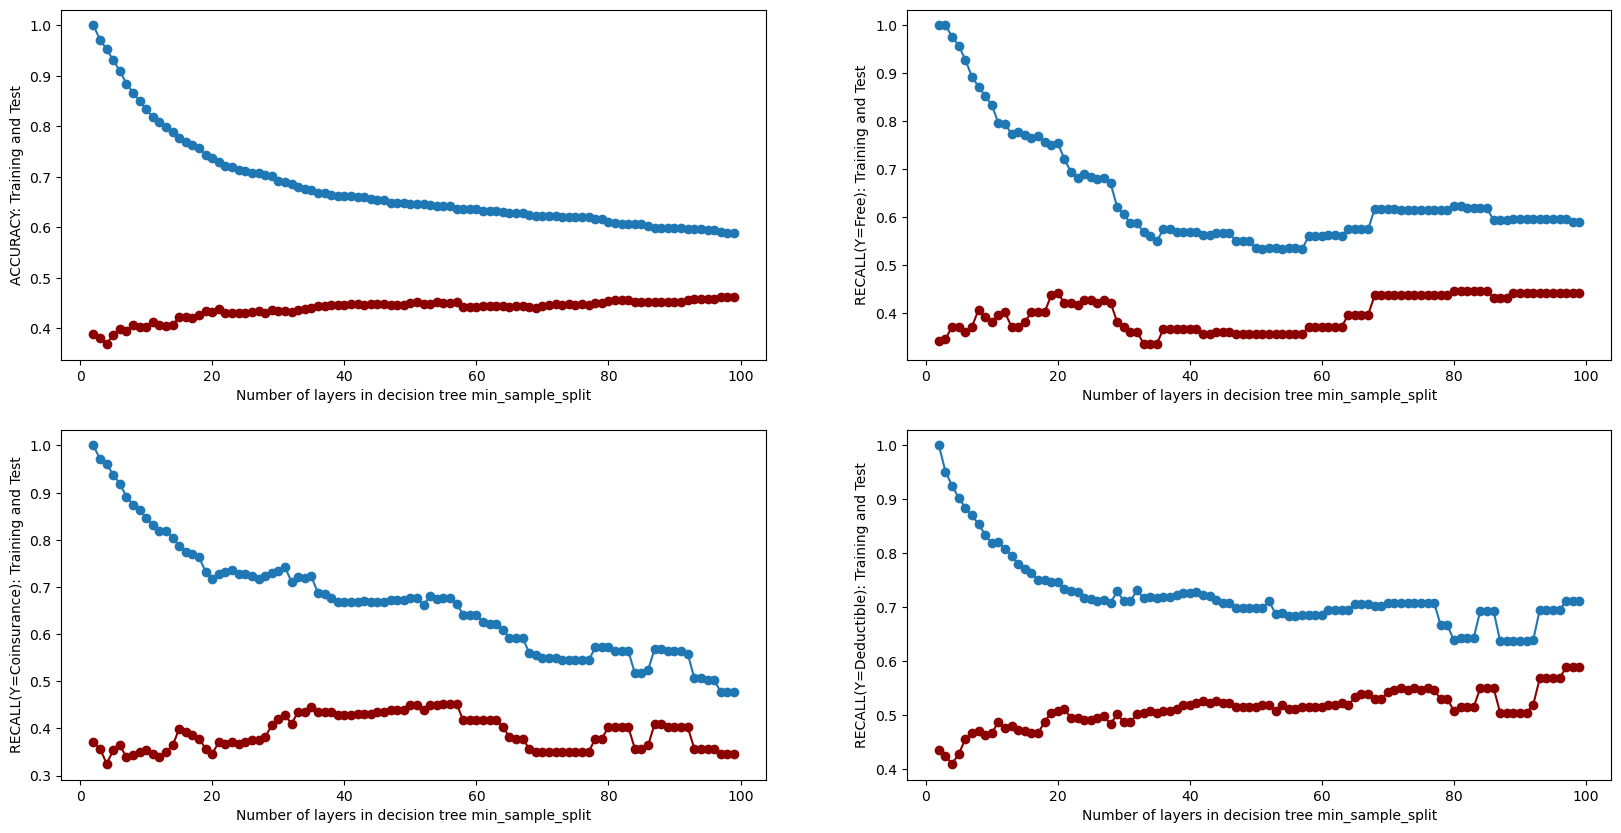

In [55]:
resultPlot(train_results,test_results, ' min_sample_split')

In [56]:
test_results=[]
train_results=[]

for crit in ['gini','entropy']:
    model = tree.DecisionTreeClassifier(criterion=crit)
    model = model.fit(x_train,y_train)

    yp_train=model.predict(x_train)
    yp_test=model.predict(x_test)

    a,b = tunningResult(y_train, y_test, yp_train, yp_test,test_results, train_results)
    # print(y_pred.shape)
    test_results.append([crit]+b)
    train_results.append([crit]+a)

test_results = pd.DataFrame(test_results)
train_results = pd.DataFrame(train_results)

print(test_results)

         0         1         2         3         4
0     gini  0.392438  0.356784  0.363958  0.445614
1  entropy  0.413299  0.381910  0.399293  0.449123


### Final Result

In [57]:
model = tree.DecisionTreeClassifier(max_depth = 4, min_samples_split = 60, criterion='entropy')
model = model.fit(x_train,y_train)

yp_train=model.predict(x_train)
yp_test=model.predict(x_test)

----------------------Classification Report---------------------------
ACCURACY: 0.47196870925684486
RECALL (Y = Free): 0.40703517587939697
RECALL (Y = Coinsurance): 0.3992932862190813
RECALL (Y = Deductible): 0.5894736842105263
PRECISION (Y = Free): 0.47368421052631576
PRECISION (Y = Coinsurance): 0.39372822299651566
PRECISION (Y = Deductible): 0.5436893203883495
--------------------------Confusion Matrix-----------------------------
[[ 81  78  40]
 [ 69 113 101]
 [ 21  96 168]]


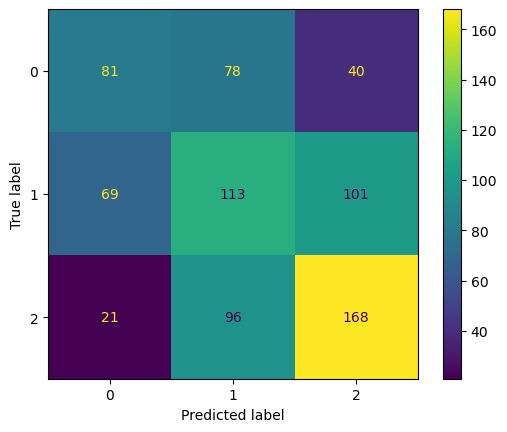

In [58]:
confusion_plot(y_test,yp_test)

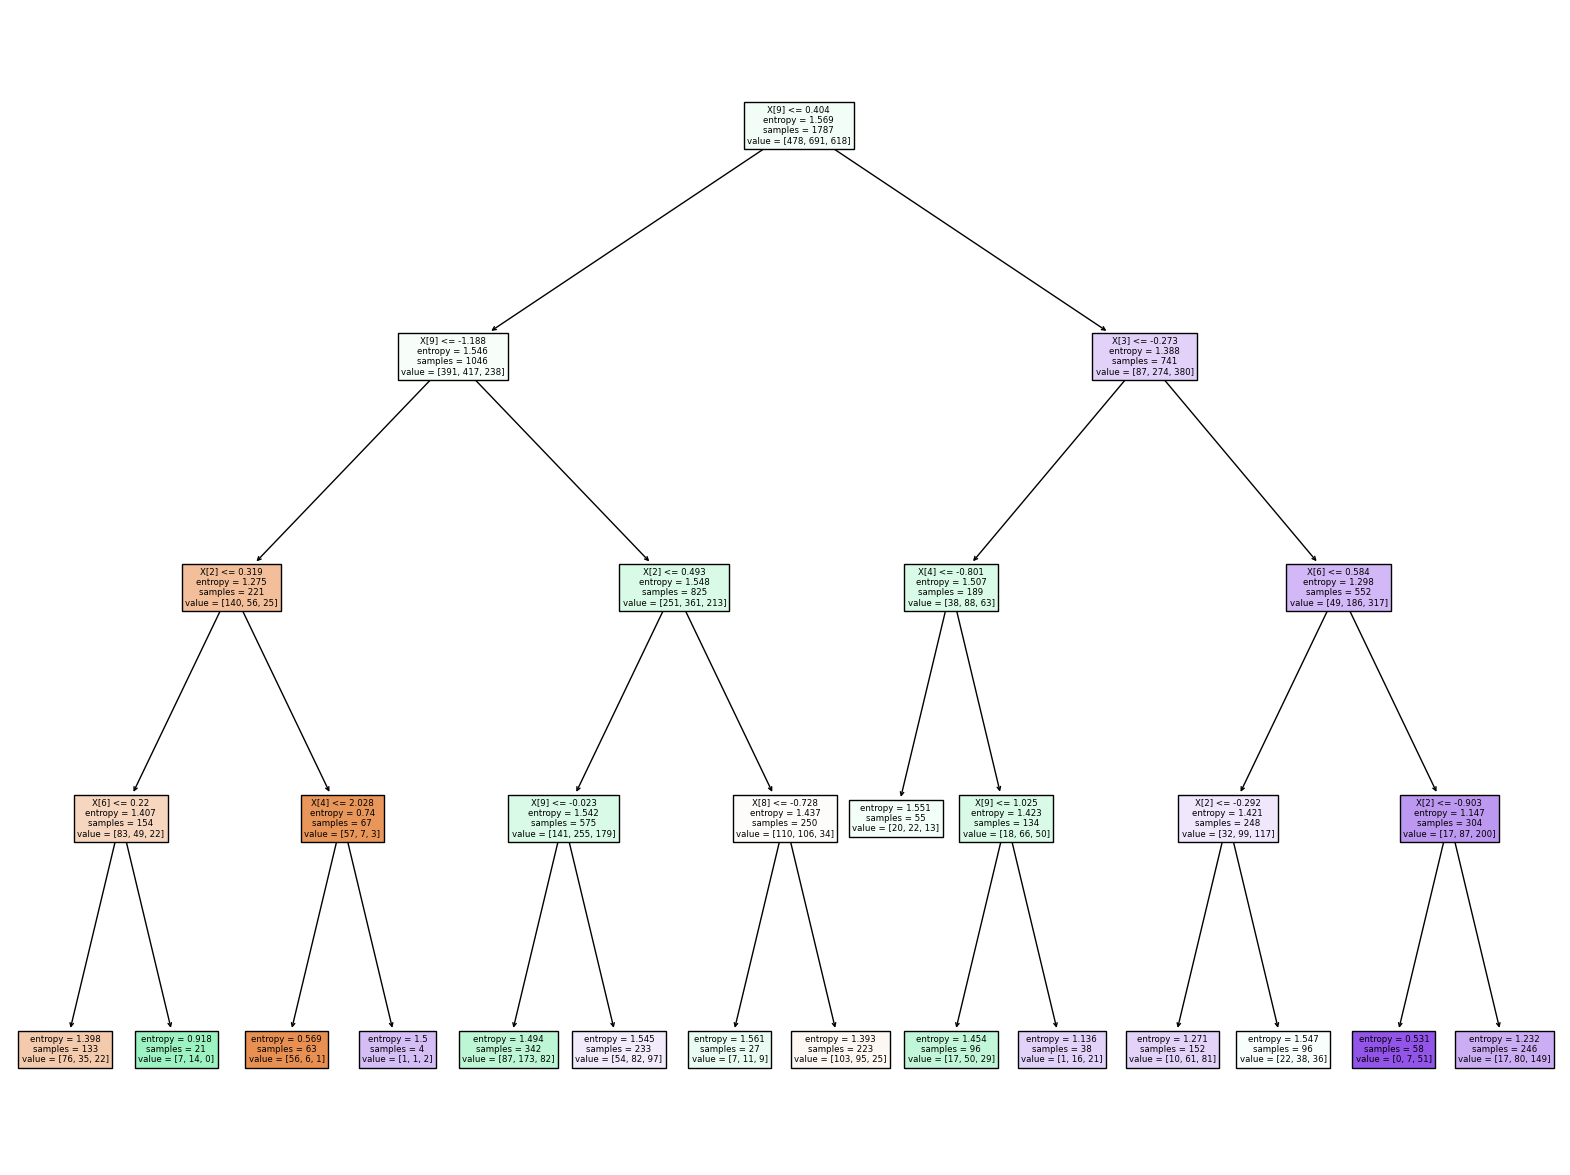

In [59]:
from sklearn import tree
def plot_tree(model):
    fig = plt.figure(figsize=(20,15))
    _ = tree.plot_tree(model, 
                    filled=True)
    plt.show()

plot_tree(model)